<a href="https://colab.research.google.com/github/immischein/ML-bandgap/blob/main/model_building_nikodemas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Packages

In [ ]:
!pip install category_encoders

# Imports

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
import shap

import category_encoders as ce
import time



# Data Imports and Processing


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# import sys
# sys.path.append('/content/drive/MyDrive/ColabImports')

# Load the CSV file (update the path to match your local filesystem)
df = pd.read_csv('INSERT YOUR PATH')  # e.g., './data/bandgap_dataset_premium.csv'

# Quick check
print(df.head())

  material_id  band_gap  formula   density       volume          a          b  \
0    mp-11107    3.5226    Ac2O3  9.109130    91.511224   4.095487   4.095489   
1    mp-32800    2.2962    Ac2S3  6.535149  1118.407852  14.997851  14.997851   
2   mp-977351    3.0275    Ac2S3  5.562971   328.464893   7.619779   7.619773   
3   mp-867311    0.0794  AcAgTe2  7.997421   122.518406   5.574922   5.574922   
4  mp-1183115    4.1024   AcAlO3  8.728230    57.451413   3.858634   3.858634   

           c       alpha        beta  ...      std_am  avg_vdw  vdw_range  \
0   6.299882   90.000000   90.000000  ...  103.368761    1.900       0.95   
1  14.997851  144.742139  144.742139  ...   95.498257    2.068       0.67   
2   7.875664  118.930903   61.069136  ...   95.498257    2.068       0.67   
3   5.574922   60.000000   60.000000  ...   46.591170    2.175       0.41   
4   3.858634   90.000000   90.000000  ...   83.410543    1.774       0.95   

   max_vdw  min_vdw   std_vdw     vbm      cbm  \


In [ ]:
df.head()

,material_id,band_gap,formula,density,volume,a,b,c,alpha,beta,...,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw,vbm,cbm,bulk_modulus,shear_modulus
0,mp-11107,3.5226,Ac2O3,9.109130,91.511224,4.095487,4.095489,6.299882,90.000000,90.000000,...,103.368761,1.900,0.95,2.47,1.52,0.465403,4.5896,8.1122,"{'voigt': 106.531, 'reuss': 96.061, 'vrh': 101...","{'voigt': 42.704, 'reuss': 28.813, 'vrh': 35.758}"
1,mp-32800,2.2962,Ac2S3,6.535149,1118.407852,14.997851,14.997851,14.997851,144.742139,144.742139,...,95.498257,2.068,0.67,2.47,1.80,0.328232,4.8014,7.0976,NaN,NaN
2,mp-977351,3.0275,Ac2S3,5.562971,328.464893,7.619779,7.619773,7.875664,118.930903,61.069136,...,95.498257,2.068,0.67,2.47,1.80,0.328232,2.9069,5.9344,NaN,NaN
3,mp-867311,0.0794,AcAgTe2,7.997421,122.518406,5.574922,5.574922,5.574922,60.000000,60.000000,...,46.591170,2.175,0.41,2.47,2.06,0.171537,5.9961,6.0755,NaN,NaN
4,mp-1183115,4.1024,AcAlO3,8.728230,57.451413,3.858634,3.858634,3.858634,90.000000,90.000000,...,83.410543,1.774,0.95,2.47,1.52,0.369410,6.8036,10.9060,NaN,NaN


In [ ]:
# To test script: load dummy data

#from sklearn.datasets import fetch_openml

# Load a regression dataset from OpenML
#data = fetch_openml(name="house_prices", as_frame=True)  # Ames housing data
#df = data.frame

# Rename target to match our script
#df = df.rename(columns={"SalePrice": "band_gap"})

In [ ]:
df.head()

,material_id,band_gap,formula,density,volume,a,b,c,alpha,beta,...,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw,vbm,cbm,bulk_modulus,shear_modulus
0,mp-11107,3.5226,Ac2O3,9.109130,91.511224,4.095487,4.095489,6.299882,90.000000,90.000000,...,103.368761,1.900,0.95,2.47,1.52,0.465403,4.5896,8.1122,"{'voigt': 106.531, 'reuss': 96.061, 'vrh': 101...","{'voigt': 42.704, 'reuss': 28.813, 'vrh': 35.758}"
1,mp-32800,2.2962,Ac2S3,6.535149,1118.407852,14.997851,14.997851,14.997851,144.742139,144.742139,...,95.498257,2.068,0.67,2.47,1.80,0.328232,4.8014,7.0976,NaN,NaN
2,mp-977351,3.0275,Ac2S3,5.562971,328.464893,7.619779,7.619773,7.875664,118.930903,61.069136,...,95.498257,2.068,0.67,2.47,1.80,0.328232,2.9069,5.9344,NaN,NaN
3,mp-867311,0.0794,AcAgTe2,7.997421,122.518406,5.574922,5.574922,5.574922,60.000000,60.000000,...,46.591170,2.175,0.41,2.47,2.06,0.171537,5.9961,6.0755,NaN,NaN
4,mp-1183115,4.1024,AcAlO3,8.728230,57.451413,3.858634,3.858634,3.858634,90.000000,90.000000,...,83.410543,1.774,0.95,2.47,1.52,0.369410,6.8036,10.9060,NaN,NaN


In [ ]:
# Data inspection

print("Data shape:", df.shape)

missing = df.isnull().sum()
missing = missing[missing > 0]
print("Missing values per column:")
for col, n in missing.items():
    print(f"{col}: {n}")

display(df.describe())

Data shape: (82998, 40)
Missing values per column:
formula: 1
avg_en: 9
max_en: 9
min_en: 9
std_en: 9
vbm: 876
cbm: 876
bulk_modulus: 79092
shear_modulus: 79092


,band_gap,density,volume,a,b,c,alpha,beta,gamma,n_atoms,...,max_am,min_am,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw,vbm,cbm
count,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,...,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82998.000000,82122.000000,82122.000000
mean,1.984421,4.061805,668.913474,7.669236,8.044636,11.280915,86.028830,88.065828,89.700249,42.406058,...,110.699981,17.901714,31.772083,1.769480,0.787753,2.316020,1.528267,0.290510,1.585835,3.591381
std,1.560981,1.717274,693.624420,3.177138,2.800604,6.822619,17.420383,15.977789,22.074143,40.632079,...,57.428377,18.988597,20.400828,0.193034,0.380579,0.355453,0.203977,0.132925,2.238984,2.214685
min,0.000000,0.020144,11.286588,2.363000,2.363000,2.395898,3.664087,5.397478,5.397478,1.000000,...,1.007940,1.007940,0.000000,1.100000,0.000000,1.100000,1.100000,0.000000,-14.222600,-7.360600
25%,0.653400,2.913572,254.760639,5.553544,6.015389,7.389807,77.756958,88.952439,86.976837,16.000000,...,55.845000,6.941000,15.265807,1.666000,0.540000,2.070000,1.520000,0.207338,0.166850,2.368150
50%,1.728450,3.773981,452.574159,7.012094,7.718989,9.712402,90.000000,90.000000,90.000000,29.000000,...,106.420000,15.999400,26.508649,1.729333,0.720000,2.230000,1.520000,0.267822,1.629350,3.660450
75%,3.013225,4.954535,841.664286,8.965331,9.328646,13.157808,90.000000,90.000000,99.717832,54.000000,...,151.964000,15.999400,45.960918,1.855000,0.970000,2.430000,1.520000,0.348872,2.952475,4.974900
max,17.891400,18.889325,20090.906408,46.210701,61.125585,211.425839,169.783994,169.783994,168.048246,444.000000,...,244.000000,227.000000,107.897541,3.430000,2.330000,3.430000,3.430000,1.165000,12.376100,14.341400


In [ ]:
# Drop columns that are prohibited

df = df.drop(columns='vbm')
df = df.drop(columns='cbm')
df = df.drop(columns='formula')
df = df.drop(columns='material_id')

## Band Gap Range

In [ ]:
# Specify your band gap values
# df_subset = df[(df['band_gap'] >= 0.001) & (df['band_gap'] <= 5)]
df_subset = df[(df['band_gap'] >= 2) & (df['band_gap'] <= 5)]
display(df_subset.describe())

,band_gap,density,volume,a,b,c,alpha,beta,gamma,n_atoms,...,std_ie,avg_am,max_am,min_am,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw
count,32786.000000,32786.000000,32786.000000,32786.000000,32786.000000,32786.000000,32786.000000,32786.000000,32786.000000,32786.000000,...,32786.000000,32786.000000,32786.000000,32786.000000,32786.000000,32786.000000,32786.000000,32786.000000,32786.000000,32786.000000
mean,3.161842,3.867638,738.035534,7.965027,8.188669,11.919840,84.979875,87.714424,90.967790,50.685384,...,3.144094,37.255748,112.564298,14.563831,32.235970,1.736522,0.874246,2.352651,1.478405,0.316487
std,0.799180,1.590179,661.680615,3.197001,2.673135,7.692287,16.472823,15.091962,21.652679,45.906899,...,0.952092,22.334775,56.488196,14.077353,20.468255,0.182034,0.384082,0.374298,0.192282,0.133980
min,2.000000,0.039581,11.286588,2.363000,2.363000,2.423140,5.844901,5.844901,5.844900,1.000000,...,0.000000,3.795400,6.941000,1.007940,0.000000,1.212500,0.000000,1.470000,1.100000,0.000000
25%,2.470425,2.831973,298.925505,5.772036,6.325481,7.652812,76.739942,89.658830,89.954028,20.000000,...,2.640790,22.124157,58.693400,6.941000,14.763958,1.654615,0.590000,2.070000,1.470000,0.229181
50%,3.047600,3.493197,527.460689,7.395158,8.023834,10.019387,90.000000,90.000000,90.000000,36.000000,...,3.214622,29.988225,114.818000,15.999400,27.830385,1.724605,0.790000,2.270000,1.520000,0.297608
75%,3.740300,4.632577,964.272296,9.082608,9.276155,14.027289,90.000000,90.000000,104.052064,66.000000,...,3.622864,48.145074,157.250000,15.999400,47.037076,1.812720,1.080000,2.490000,1.520000,0.371677
max,5.000000,14.034039,6901.604446,38.788312,52.349372,211.425839,168.624134,168.773147,167.256937,432.000000,...,6.385444,184.239150,238.028910,127.600000,103.368761,2.920000,2.330000,3.430000,2.140000,1.165000


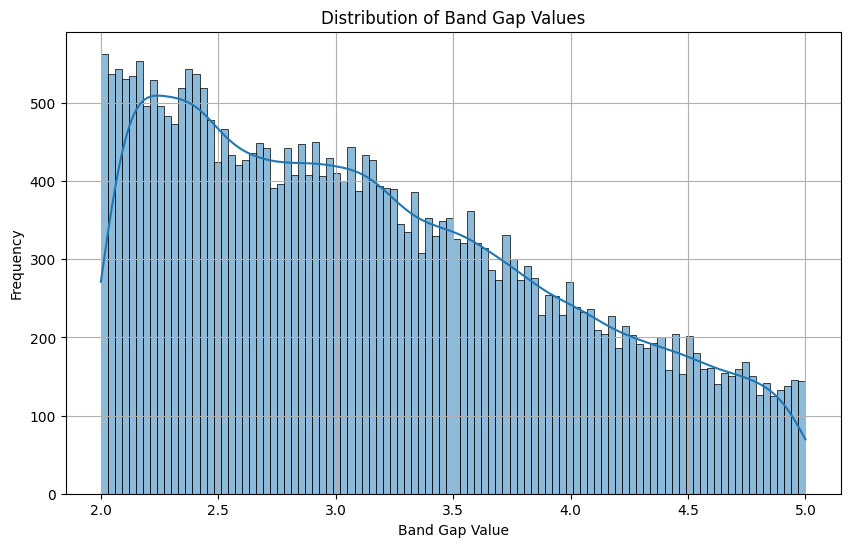

In [ ]:
# Make a plot of band gap values based on occurences
plt.figure(figsize=(10, 6))
sns.histplot(df_subset['band_gap'], bins=100, kde=True)
plt.title('Distribution of Band Gap Values')
plt.xlabel('Band Gap Value')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Define features and target

In [ ]:
target_column = "band_gap"
X = df_subset.drop(columns=[target_column])
y = df_subset[target_column]

# Seperate numeric and categorical columns

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocessing

In [ ]:
# To decide: drop columns with >65% missing values (can be lower, based on this dummy dataset)

threshold = 0.65
missing_frac = df_subset.isnull().mean()
cols_to_drop = missing_frac[missing_frac > threshold].index

print(f"Dropping columns with >{int(threshold*100)}% missing values:")
print(list(cols_to_drop))

df_subset = df_subset.drop(columns=cols_to_drop)

# To decide: impute missing numerical values with mean, categorical features with most frequent value
# StandardScaler subtracts mean and divides by std
# Use onehotencoder for categorical features


# Split into train and test sets BEFORE preprocessing
X = df_subset.drop("band_gap", axis=1)   # Replace "target" with your actual target column name
y = df_subset["band_gap"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Target Encoding on training set only
# Convert a meaningufl categorical feature into a numerical one. This is more dense that one-hot encoding
# Transform a categorical variable into a numerical one using the mean of the target variable for each category
te_col = "spacegroup_number "
te_encoder = ce.TargetEncoder(cols=[te_col])
# apply target encoding on training set
X_train[te_col] = te_encoder.fit_transform(X_train[te_col], y_train)

# apply target encoding on test set
X_test[te_col] = te_encoder.transform(X_test[te_col])


# Proceed with rest of pre-processing pipeline
# Separate numeric and categorical columns again after dropping columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Numeric features are imputed with the mean and then scaled
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="mean"), # fill missing values with mean
    StandardScaler()
)
# Categorical features are imputed with the most frequent value and then one-hot encoded
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"), # fill missing values with most frequent value
    OneHotEncoder(handle_unknown="ignore") # one-hot encode categorical features
)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Fit and transform the training data, and transform the test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

Dropping columns with >65% missing values:
['bulk_modulus', 'shear_modulus']


# Define the models to compare

In [ ]:
models = {
    "Dummy": DummyRegressor(),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(
    random_state=42,
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=3,
    min_samples_split=5,
    max_features='sqrt',
    oob_score=True,
    n_jobs=-1
)

}

# Model training

In [ ]:
# train models
print("\nCross-validated MAE (5-fold):")
for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    scores = cross_val_score(pipeline, X_train, y_train,
                             scoring="neg_mean_absolute_error", cv=5)
    print(f"{name}: MAE = {-np.mean(scores):.3f}")


Cross-validated MAE (5-fold):
Dummy: MAE = 0.673
Linear Regression: MAE = 0.619
Ridge Regression: MAE = 0.619
Random Forest: MAE = 0.439


In [ ]:
# Evaluate data on random forest model from above
models["Random Forest"].fit(X_train_processed, y_train)
y_pred = models["Random Forest"].predict(X_test_processed)
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred))


# Evaluate model


Test set performance:
Dummy: MAE = 0.674, R² = -0.000
Linear Regression: MAE = 0.625, R² = 0.120
Ridge Regression: MAE = 0.625, R² = 0.120
Random Forest: MAE = 0.427, R² = 0.535


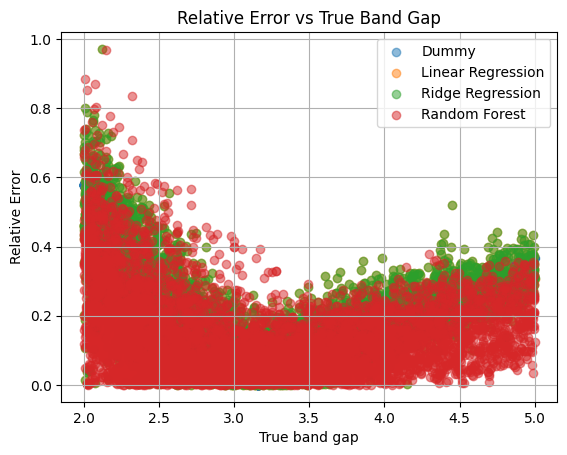

In [ ]:
# Fit on full training set and evaluate on test set

results = {}
print("\nTest set performance:")
for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"mae": mae, "r2": r2}

    print(f"{name}: MAE = {mae:.3f}, R² = {r2:.3f}")

    # Plot MAE vs true value
    relative_error = np.abs(y_pred - y_test) / y_test
    plt.scatter(y_test, relative_error, label=name, alpha=0.5)

    #plt.scatter(y_test, np.abs(y_pred - y_test), label=name, alpha=0.5)

plt.xlabel("True band gap")
plt.ylabel("Relative Error")
plt.title("Relative Error vs True Band Gap")
plt.legend()
plt.grid(True)
plt.show()


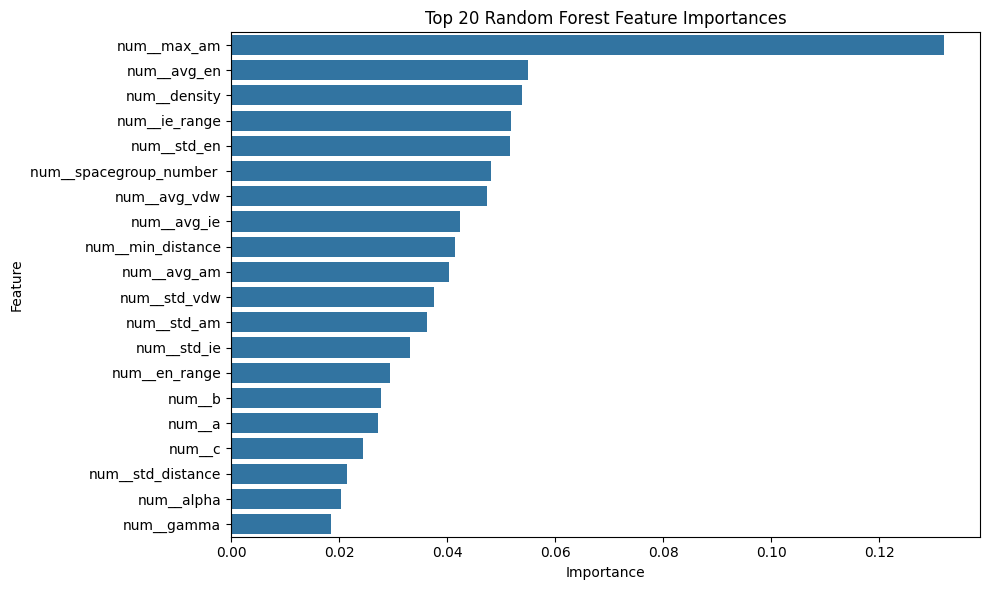

In [ ]:
# Feature importance of tree based model
rf_model = make_pipeline(preprocessor, RandomForestRegressor(random_state=42))
rf_model.fit(X_train, y_train)

importances = rf_model.named_steps["randomforestregressor"].feature_importances_

# Get feature names from the preprocessor
feature_names = rf_model.named_steps["columntransformer"].get_feature_names_out()

# Sort by importance
sorted_idx = np.argsort(importances)[::-1][:20]
top_features = np.array(feature_names)[sorted_idx]
top_importances = importances[sorted_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features)
plt.title("Top 20 Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
# # Feature importance using SHAP
# rf = rf_model.named_steps["randomforestregressor"]
# X_transformed = rf_model.named_steps["columntransformer"].transform(X_test)

# if hasattr(X_transformed, "toarray"):
#     X_transformed = X_transformed.toarray()

# feature_names = rf_model.named_steps["columntransformer"].get_feature_names_out()

# explainer = shap.TreeExplainer(rf)
# shap_values = explainer.shap_values(X_transformed)

# shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)


In [ ]:
# # Using a faster SHAP explainer
# rf = rf_model.named_steps["randomforestregressor"]

# # Sample fewer rows for faster explanation
# X_sample = X_test.sample(250, random_state=42)

# # Transform using your pipeline
# X_transformed = rf_model.named_steps["columntransformer"].transform(X_sample)

# # Only convert if needed
# if hasattr(X_transformed, "toarray"):
#     X_transformed = X_transformed.toarray()

# # Get feature names
# feature_names = rf_model.named_steps["columntransformer"].get_feature_names_out()

# # Use SHAP's auto-detect explainer (faster in new versions)
# explainer = shap.Explainer(rf)

# # Compute SHAP values
# shap_values = explainer(X_transformed)

# # Summary plot
# shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)


# Deep Learning Code

### Multilayer Perceptron (MLP)

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Model training
mlp = MLPRegressor(hidden_layer_sizes=(500, 50),
                   batch_size=32,
                   learning_rate_init=0.001,
                   activation='relu',
                   solver='adam',
                   max_iter=500,
                   random_state=42,
                   early_stopping=True,
                   validation_fraction=0.01,
                   verbose=True)

mlp.fit(X_train_processed, y_train)

Iteration 1, loss = 0.32849071
Validation score: 0.217295
Iteration 2, loss = 0.25874542
Validation score: 0.229804
Iteration 3, loss = 0.24624199
Validation score: 0.229363
Iteration 4, loss = 0.23651893
Validation score: 0.225040
Iteration 5, loss = 0.22996529
Validation score: 0.306302
Iteration 6, loss = 0.22511973
Validation score: 0.273042
Iteration 7, loss = 0.21827359
Validation score: 0.309634
Iteration 8, loss = 0.21443324
Validation score: 0.330448
Iteration 9, loss = 0.21014364
Validation score: 0.297989
Iteration 10, loss = 0.20625983
Validation score: 0.344994
Iteration 11, loss = 0.20266881
Validation score: 0.293596
Iteration 12, loss = 0.19925455
Validation score: 0.325306
Iteration 13, loss = 0.19559663
Validation score: 0.362221
Iteration 14, loss = 0.19206653
Validation score: 0.344506
Iteration 15, loss = 0.18764141
Validation score: 0.364928
Iteration 16, loss = 0.18653069
Validation score: 0.357117
Iteration 17, loss = 0.18379848
Validation score: 0.353925
Iterat

MLPRegressor(batch_size=32, early_stopping=True, hidden_layer_sizes=(500, 50),
             max_iter=500, random_state=42, validation_fraction=0.01,
             verbose=True)

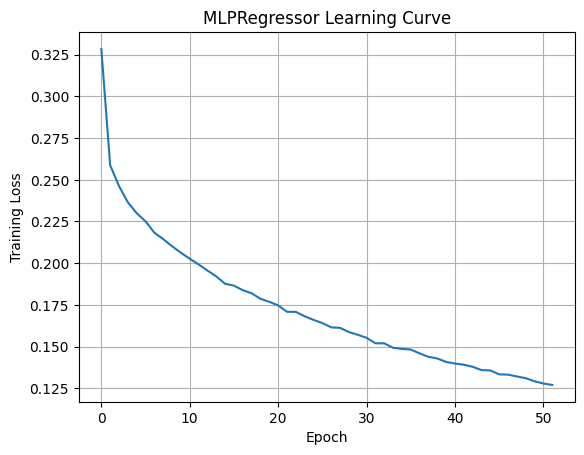

In [ ]:
# Plot learning curve
plt.plot(mlp.loss_curve_)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("MLPRegressor Learning Curve")
plt.grid(True)
plt.show()

In [ ]:
# Evaluate performance
y_pred_sklearn = mlp.predict(X_test_processed)

mae_mlp = mean_absolute_error(y_test, y_pred_sklearn)
r2_mlp = r2_score(y_test, y_pred_sklearn)
mse_mlp = mean_squared_error(y_test, y_pred_sklearn)
rmse_mlp = np.sqrt(mse_mlp)

print(f"[MLPRegressor]")
print(f"MAE:  {mae_mlp:.4f}")
print(f"RMSE: {rmse_mlp:.4f}")
print(f"R²:   {r2_mlp:.4f}")


[MLPRegressor]
MAE:  0.4860
RMSE: 0.6186
R²:   0.4069


### Deep Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed.toarray()
                              if hasattr(X_train_processed, "toarray")
                              else X_train_processed, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_processed.toarray()
                             if hasattr(X_test_processed, "toarray")
                             else X_test_processed, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [ ]:
# Define model
class DeepRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)

        )

    def forward(self, x):

        return self.net(x)

model_layers3 = DeepRegressor(X_train_tensor.shape[1])


In [ ]:
# Put the model on the GPU if available
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal GPU on Mac
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU (not on Mac usually)
else:
    device = torch.device("cpu")  # Fallback

print("Using device:", device)

model_layers3.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print(X_train_tensor.device)
print(y_train_tensor.device)

Using device: mps
mps:0
mps:0


In [ ]:
# # Train model and register learning curve

# # Start timing
# start_time = time.time()

# # Define loss function: Mean Squared Error is commonly used for regression
# criterion = nn.MSELoss()

# # Define optimizer: Adam is an adaptive optimizer that generally performs well
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Lists to store training and test loss values at each epoch (for plotting/monitoring)
# train_losses = []
# test_losses = []

# # Set total number of training epochs
# n_epochs = 10000

# # Start the training loop
# for epoch in range(n_epochs):
#     # Set the model to training mode (activates dropout, batchnorm, etc. if used)
#     model.train()

#     # Clear previous gradients to prevent accumulation
#     optimizer.zero_grad()

#     # Forward pass: predict training outputs using current model weights
#     y_pred_train = model(X_train_tensor)

#     # Compute training loss by comparing predictions to ground truth
#     loss = criterion(y_pred_train, y_train_tensor)

#     # Backward pass: compute gradients of the loss w.r.t. model parameters
#     loss.backward()

#     # Update model weights using the computed gradients
#     optimizer.step()

#     # Switch model to evaluation mode (disables dropout, uses running stats for batchnorm)
#     model.eval()

#     # Disable gradient computation during inference to save memory and improve speed
#     with torch.no_grad():
#         # Predict outputs on the test set
#         y_pred_test = model(X_test_tensor)

#         # Compute test loss for evaluation
#         test_loss = criterion(y_pred_test, y_test_tensor)

#     # Record training and test loss values for this epoch
#     train_losses.append(loss.item())
#     test_losses.append(test_loss.item())

#     # Print progress every 10 epochs
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}: Train Loss={loss.item():.4f}, Test Loss={test_loss.item():.4f}")

# # End timing
# end_time = time.time()
# training_time_3layers = end_time - start_time
# print(f"Training time: {training_time_3layers:.2f} seconds")


Define the training loop

In [ ]:
import time
from tqdm import trange
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(
    model,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    n_epochs=5000,
    lr=0.001,
    weight_decay=0,
    early_stop_patience=200,
    scheduler_patience=50,
    scheduler_factor=0.5,
    verbose_every=10
):
    """
    Trains a PyTorch regression model with early stopping and learning rate scheduling.

    Returns:
        model: The trained model with best weights
        train_losses: List of training loss per epoch
        test_losses: List of test loss per epoch
    """

    # Setup
    start_time = time.time()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience
    )

    train_losses = []
    test_losses = []
    best_loss = float('inf')
    trigger_times = 0

    for epoch in trange(n_epochs, desc="Training"):
        model.train()
        optimizer.zero_grad()
        y_pred_train = model(X_train_tensor)
        loss = criterion(y_pred_train, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            y_pred_test = model(X_test_tensor)
            test_loss = criterion(y_pred_test, y_test_tensor)

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        scheduler.step(test_loss.item())

        # Early stopping
        if test_loss.item() < best_loss:
            best_loss = test_loss.item()
            best_model_state = model.state_dict()
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= early_stop_patience:
                print(f"\n⏹️ Early stopping at epoch {epoch}")
                break
        # if epoch % verbose_every == 0:
        #     tqdm.write(f"Epoch {epoch:4d} | Train Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f}")
        # Print progress
        if epoch % verbose_every == 0:
            print(f"Epoch {epoch:4d} | Train Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f}")

    # Restore best model weights
    model.load_state_dict(best_model_state)

    # Report training time
    end_time = time.time()
    duration = end_time - start_time
    print(f"\n✅ Training completed in {duration:.2f} seconds ({duration / 60:.2f} minutes)")

    return model, train_losses, test_losses


In [ ]:
model_layers3, train_losses_layers3, test_losses_layers3 = train_model(
    model_layers3,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    n_epochs=5000,
    lr=0.001,
    weight_decay=0,
    early_stop_patience=200,
    scheduler_patience=50,
    scheduler_factor=0.5,
    verbose_every=20
)

Training:   0%|          | 11/5000 [00:00<03:32, 23.44it/s]

Epoch    0 | Train Loss: 11.1081 | Test Loss: 10.7698
Epoch   20 | Train Loss: 3.8926 | Test Loss: 3.6090


Training:   1%|          | 55/5000 [00:01<01:05, 75.09it/s]

Epoch   40 | Train Loss: 1.6328 | Test Loss: 1.5449


Training:   2%|▏         | 76/5000 [00:01<01:05, 74.94it/s]

Epoch   60 | Train Loss: 1.1092 | Test Loss: 1.1048
Epoch   80 | Train Loss: 0.9397 | Test Loss: 0.9439


Training:   2%|▏         | 109/5000 [00:01<01:00, 81.41it/s]

Epoch  100 | Train Loss: 0.8532 | Test Loss: 0.8646


Training:   3%|▎         | 133/5000 [00:01<00:51, 95.23it/s]

Epoch  120 | Train Loss: 0.7983 | Test Loss: 0.8114
Epoch  140 | Train Loss: 0.7562 | Test Loss: 0.7698


Training:   4%|▎         | 183/5000 [00:02<00:41, 114.98it/s]

Epoch  160 | Train Loss: 0.7206 | Test Loss: 0.7350
Epoch  180 | Train Loss: 0.6891 | Test Loss: 0.7044


Training:   4%|▍         | 209/5000 [00:02<00:46, 102.84it/s]

Epoch  200 | Train Loss: 0.6608 | Test Loss: 0.6769
Epoch  220 | Train Loss: 0.6355 | Test Loss: 0.6520


Training:   5%|▌         | 265/5000 [00:03<00:38, 123.17it/s]

Epoch  240 | Train Loss: 0.6130 | Test Loss: 0.6298
Epoch  260 | Train Loss: 0.5928 | Test Loss: 0.6096


Training:   6%|▌         | 309/5000 [00:03<00:34, 134.81it/s]

Epoch  280 | Train Loss: 0.5746 | Test Loss: 0.5913
Epoch  300 | Train Loss: 0.5581 | Test Loss: 0.5746


Training:   7%|▋         | 337/5000 [00:03<00:35, 132.95it/s]

Epoch  320 | Train Loss: 0.5432 | Test Loss: 0.5598
Epoch  340 | Train Loss: 0.5302 | Test Loss: 0.5465


Training:   8%|▊         | 380/5000 [00:03<00:34, 135.25it/s]

Epoch  360 | Train Loss: 0.5186 | Test Loss: 0.5345
Epoch  380 | Train Loss: 0.5080 | Test Loss: 0.5235


Training:   8%|▊         | 408/5000 [00:04<00:36, 125.87it/s]

Epoch  400 | Train Loss: 0.4985 | Test Loss: 0.5143


Training:   9%|▊         | 434/5000 [00:04<00:43, 103.93it/s]

Epoch  420 | Train Loss: 0.4901 | Test Loss: 0.5061
Epoch  440 | Train Loss: 0.4825 | Test Loss: 0.4991


Training:  10%|▉         | 475/5000 [00:04<00:37, 119.74it/s]

Epoch  460 | Train Loss: 0.4753 | Test Loss: 0.4930
Epoch  480 | Train Loss: 0.4683 | Test Loss: 0.4876


Training:  10%|█         | 513/5000 [00:05<00:38, 116.91it/s]

Epoch  500 | Train Loss: 0.4619 | Test Loss: 0.4831
Epoch  520 | Train Loss: 0.4557 | Test Loss: 0.4792


Training:  11%|█         | 555/5000 [00:05<00:34, 130.52it/s]

Epoch  540 | Train Loss: 0.4501 | Test Loss: 0.4757
Epoch  560 | Train Loss: 0.4451 | Test Loss: 0.4725


Training:  12%|█▏        | 595/5000 [00:05<00:36, 121.76it/s]

Epoch  580 | Train Loss: 0.4403 | Test Loss: 0.4695
Epoch  600 | Train Loss: 0.4360 | Test Loss: 0.4671


Training:  13%|█▎        | 632/5000 [00:06<00:38, 114.86it/s]

Epoch  620 | Train Loss: 0.4317 | Test Loss: 0.4645
Epoch  640 | Train Loss: 0.4275 | Test Loss: 0.4620


Training:  13%|█▎        | 674/5000 [00:06<00:35, 122.91it/s]

Epoch  660 | Train Loss: 0.4236 | Test Loss: 0.4605
Epoch  680 | Train Loss: 0.4198 | Test Loss: 0.4588


Training:  14%|█▍        | 712/5000 [00:06<00:36, 117.57it/s]

Epoch  700 | Train Loss: 0.4162 | Test Loss: 0.4569
Epoch  720 | Train Loss: 0.4128 | Test Loss: 0.4554


Training:  15%|█▌        | 754/5000 [00:07<00:34, 123.60it/s]

Epoch  740 | Train Loss: 0.4097 | Test Loss: 0.4540
Epoch  760 | Train Loss: 0.4067 | Test Loss: 0.4529


Training:  16%|█▌        | 796/5000 [00:07<00:37, 113.04it/s]

Epoch  780 | Train Loss: 0.4038 | Test Loss: 0.4516


Training:  16%|█▋        | 823/5000 [00:07<00:34, 120.61it/s]

Epoch  800 | Train Loss: 0.4010 | Test Loss: 0.4505
Epoch  820 | Train Loss: 0.3982 | Test Loss: 0.4495


Training:  17%|█▋        | 864/5000 [00:07<00:33, 121.91it/s]

Epoch  840 | Train Loss: 0.3957 | Test Loss: 0.4491
Epoch  860 | Train Loss: 0.3928 | Test Loss: 0.4480


Training:  18%|█▊        | 904/5000 [00:08<00:33, 122.20it/s]

Epoch  880 | Train Loss: 0.3902 | Test Loss: 0.4468
Epoch  900 | Train Loss: 0.3875 | Test Loss: 0.4460


Training:  19%|█▊        | 934/5000 [00:08<00:31, 131.03it/s]

Epoch  920 | Train Loss: 0.3851 | Test Loss: 0.4452
Epoch  940 | Train Loss: 0.3828 | Test Loss: 0.4447


Training:  20%|█▉        | 978/5000 [00:08<00:32, 123.33it/s]

Epoch  960 | Train Loss: 0.3809 | Test Loss: 0.4448
Epoch  980 | Train Loss: 0.3781 | Test Loss: 0.4438


Training:  20%|██        | 1019/5000 [00:09<00:30, 129.73it/s]

Epoch 1000 | Train Loss: 0.3756 | Test Loss: 0.4430
Epoch 1020 | Train Loss: 0.3735 | Test Loss: 0.4425


Training:  21%|██        | 1061/5000 [00:09<00:30, 130.43it/s]

Epoch 1040 | Train Loss: 0.3715 | Test Loss: 0.4420
Epoch 1060 | Train Loss: 0.3694 | Test Loss: 0.4414


Training:  22%|██▏       | 1102/5000 [00:09<00:30, 127.66it/s]

Epoch 1080 | Train Loss: 0.3682 | Test Loss: 0.4423
Epoch 1100 | Train Loss: 0.3658 | Test Loss: 0.4412


Training:  23%|██▎       | 1147/5000 [00:10<00:29, 132.27it/s]

Epoch 1120 | Train Loss: 0.3641 | Test Loss: 0.4409
Epoch 1140 | Train Loss: 0.3625 | Test Loss: 0.4409


Training:  23%|██▎       | 1174/5000 [00:10<00:30, 125.58it/s]

Epoch 1160 | Train Loss: 0.3612 | Test Loss: 0.4405
Epoch 1180 | Train Loss: 0.3592 | Test Loss: 0.4395


Training:  24%|██▍       | 1213/5000 [00:10<00:31, 120.45it/s]

Epoch 1200 | Train Loss: 0.3576 | Test Loss: 0.4391
Epoch 1220 | Train Loss: 0.3591 | Test Loss: 0.4427


Training:  25%|██▌       | 1265/5000 [00:11<00:30, 122.00it/s]

Epoch 1240 | Train Loss: 0.3548 | Test Loss: 0.4385
Epoch 1260 | Train Loss: 0.3532 | Test Loss: 0.4382


Training:  26%|██▌       | 1305/5000 [00:11<00:30, 121.24it/s]

Epoch 1280 | Train Loss: 0.3519 | Test Loss: 0.4377
Epoch 1300 | Train Loss: 0.3504 | Test Loss: 0.4376


Training:  27%|██▋       | 1345/5000 [00:11<00:29, 122.08it/s]

Epoch 1320 | Train Loss: 0.3491 | Test Loss: 0.4372
Epoch 1340 | Train Loss: 0.3482 | Test Loss: 0.4375


Training:  28%|██▊       | 1386/5000 [00:12<00:29, 123.16it/s]

Epoch 1360 | Train Loss: 0.3470 | Test Loss: 0.4368
Epoch 1380 | Train Loss: 0.3458 | Test Loss: 0.4369


Training:  29%|██▊       | 1429/5000 [00:12<00:26, 134.05it/s]

Epoch 1400 | Train Loss: 0.3441 | Test Loss: 0.4365
Epoch 1420 | Train Loss: 0.3430 | Test Loss: 0.4367


Training:  29%|██▉       | 1458/5000 [00:12<00:27, 130.77it/s]

Epoch 1440 | Train Loss: 0.3417 | Test Loss: 0.4365
Epoch 1460 | Train Loss: 0.3411 | Test Loss: 0.4365


Training:  30%|███       | 1502/5000 [00:12<00:27, 126.90it/s]

Epoch 1480 | Train Loss: 0.3405 | Test Loss: 0.4365
Epoch 1500 | Train Loss: 0.3402 | Test Loss: 0.4366


Training:  31%|███       | 1542/5000 [00:13<00:27, 126.91it/s]

Epoch 1520 | Train Loss: 0.3399 | Test Loss: 0.4366
Epoch 1540 | Train Loss: 0.3396 | Test Loss: 0.4367


Training:  31%|███▏      | 1568/5000 [00:13<00:27, 122.88it/s]

Epoch 1560 | Train Loss: 0.3395 | Test Loss: 0.4367


Training:  32%|███▏      | 1583/5000 [00:13<00:29, 115.10it/s]

Epoch 1580 | Train Loss: 0.3393 | Test Loss: 0.4367

⏹️ Early stopping at epoch 1583

✅ Training completed in 13.76 seconds (0.23 minutes)


Evaluate the model

In [ ]:
# Model evaluation
def evaluate_model(model, X_train_tensor, y_train, X_test_tensor, y_test, y_train_tensor=None):
    """
    Evaluates a trained PyTorch regression model on both training and test sets.

    Returns:
        Dictionary of metrics (MAE, RMSE, R²) for train and test sets
    """
    model.eval()

    with torch.no_grad():
        y_pred_test = model(X_test_tensor).detach().cpu().numpy()
        y_pred_train = model(X_train_tensor).detach().cpu().numpy()


    # Evaluate on test set
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_pred_test)

    # Evaluate on train set
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_pred_train)

    return {
        "test": {"MAE": mae_test, "RMSE": rmse_test, "R2": r2_test, "y_pred_test": y_pred_test},
        "train": {"MAE": mae_train, "RMSE": rmse_train, "R2": r2_train, "y_pred_train": y_pred_train}
    }

Analyze the model

In [ ]:
# Plot learning curves
import matplotlib.pyplot as plt

def analyze_model(metrics, y_test,
                  train_losses, test_losses, model_name="PyTorch Model"):
    """
    Plots learning curves, prints metrics, and plots predicted vs. true values.
    """

    # 2. Plot learning curves
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title(f"{model_name} Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3. Print metrics
    print(f"[{model_name} - Test Set]")
    print(f"MAE:  {metrics['test']['MAE']:.4f}")
    print(f"RMSE: {metrics['test']['RMSE']:.4f}")
    print(f"R²:   {metrics['test']['R2']:.4f}")
    print(f"\n[{model_name} - Training Set]")
    print(f"MAE:  {metrics['train']['MAE']:.4f}")
    print(f"RMSE: {metrics['train']['RMSE']:.4f}")
    print(f"R²:   {metrics['train']['R2']:.4f}")

    # 4. Plot predicted vs true values (test set)

    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, metrics['test']['y_pred_test'], alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel("True Band Gap")
    plt.ylabel("Predicted Band Gap")
    plt.title(f"{model_name} - Predicted vs True (Test Set)")
    plt.grid(True)
    plt.show()


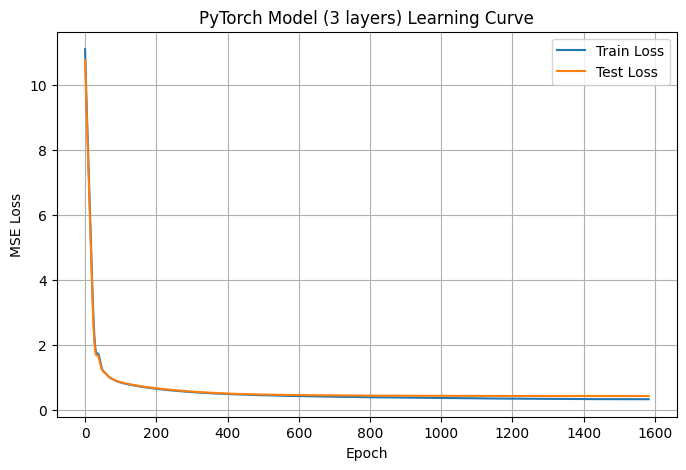

[PyTorch Model (3 layers) - Test Set]
MAE:  0.5278
RMSE: 0.6608
R²:   0.3233

[PyTorch Model (3 layers) - Training Set]
MAE:  0.4646
RMSE: 0.5825
R²:   0.4674


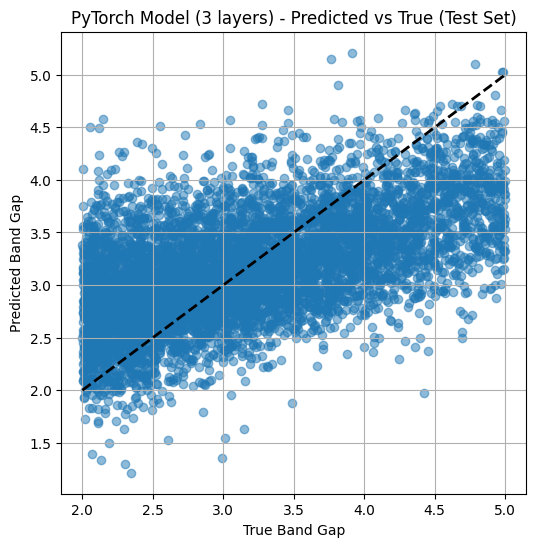

In [ ]:
# Make a metrics dictionary
model_layers3_metrics = evaluate_model(
    model_layers3,
    X_train_tensor,
    y_train,
    X_test_tensor,
    y_test
)
# Analyze the model
analyze_model(
    model_layers3_metrics,
    y_test,
    train_losses_layers3,
    test_losses_layers3,
    model_name="PyTorch Model (3 layers)"
)

### 6 Layers Even Deeper Network

In [ ]:
class DeepRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(  # Define the network layers
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2), # Drops 20% of neurons randomly during training

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2), # Drops 20% of neurons randomly during training

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 1)  # Output layer (no activation for regression)
        )

    def forward(self, x):
        return self.net(x)

# Initialize the model with the input dimension (number of features)
model_layers6 = DeepRegressor(X_train_tensor.shape[1])

#### Run code on GPU

In [ ]:

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal GPU on Mac
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU (not on Mac usually)
else:
    device = torch.device("cpu")  # Fallback

print("Using device:", device)

model_layers6.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print(X_train_tensor.device)
print(y_train_tensor.device)

Using device: mps
mps:0
mps:0


In [ ]:
model_layers6, train_losses_layers6, test_losses_layers6 = train_model(
    model_layers6,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    n_epochs=5000,
    lr=0.001,
    weight_decay=0,
    early_stop_patience=200,
    scheduler_patience=50,
    scheduler_factor=0.5,
    verbose_every=20
)

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch    0 | Train Loss: 10.7176 | Test Loss: 10.6895


Training:   1%|          | 35/5000 [00:00<01:11, 68.96it/s]

Epoch   20 | Train Loss: 2.6274 | Test Loss: 2.6273


Training:   1%|          | 49/5000 [00:00<01:12, 68.13it/s]

Epoch   40 | Train Loss: 1.1745 | Test Loss: 1.1106


Training:   1%|▏         | 73/5000 [00:01<01:09, 70.64it/s]

Epoch   60 | Train Loss: 0.9598 | Test Loss: 0.8948


Training:   2%|▏         | 89/5000 [00:01<01:09, 70.91it/s]

Epoch   80 | Train Loss: 0.8637 | Test Loss: 0.8127


Training:   2%|▏         | 113/5000 [00:01<01:08, 71.06it/s]

Epoch  100 | Train Loss: 0.7995 | Test Loss: 0.7489


Training:   3%|▎         | 129/5000 [00:01<01:08, 71.32it/s]

Epoch  120 | Train Loss: 0.7467 | Test Loss: 0.6930


Training:   3%|▎         | 153/5000 [00:02<01:08, 71.06it/s]

Epoch  140 | Train Loss: 0.6962 | Test Loss: 0.6435


Training:   3%|▎         | 169/5000 [00:02<01:08, 70.79it/s]

Epoch  160 | Train Loss: 0.6615 | Test Loss: 0.6026


Training:   4%|▍         | 193/5000 [00:02<01:07, 71.45it/s]

Epoch  180 | Train Loss: 0.6333 | Test Loss: 0.5724


Training:   4%|▍         | 209/5000 [00:02<01:07, 71.40it/s]

Epoch  200 | Train Loss: 0.6126 | Test Loss: 0.5515


Training:   5%|▍         | 233/5000 [00:03<01:06, 72.19it/s]

Epoch  220 | Train Loss: 0.5916 | Test Loss: 0.5360


Training:   5%|▍         | 249/5000 [00:03<01:04, 73.41it/s]

Epoch  240 | Train Loss: 0.5745 | Test Loss: 0.5274


Training:   5%|▌         | 273/5000 [00:03<01:04, 73.18it/s]

Epoch  260 | Train Loss: 0.5597 | Test Loss: 0.5160


Training:   6%|▌         | 289/5000 [00:04<01:03, 74.12it/s]

Epoch  280 | Train Loss: 0.5475 | Test Loss: 0.5095


Training:   6%|▋         | 313/5000 [00:04<01:02, 74.52it/s]

Epoch  300 | Train Loss: 0.5398 | Test Loss: 0.4971


Training:   7%|▋         | 329/5000 [00:04<01:02, 74.97it/s]

Epoch  320 | Train Loss: 0.5249 | Test Loss: 0.4998


Training:   7%|▋         | 353/5000 [00:04<01:03, 73.30it/s]

Epoch  340 | Train Loss: 0.5187 | Test Loss: 0.4900


Training:   7%|▋         | 369/5000 [00:05<01:03, 73.27it/s]

Epoch  360 | Train Loss: 0.5097 | Test Loss: 0.4815


Training:   8%|▊         | 393/5000 [00:05<01:02, 73.67it/s]

Epoch  380 | Train Loss: 0.5006 | Test Loss: 0.4853


Training:   8%|▊         | 409/5000 [00:05<01:02, 73.64it/s]

Epoch  400 | Train Loss: 0.4891 | Test Loss: 0.4852


Training:   9%|▊         | 433/5000 [00:06<01:01, 74.30it/s]

Epoch  420 | Train Loss: 0.4866 | Test Loss: 0.4797


Training:   9%|▉         | 449/5000 [00:06<01:01, 73.47it/s]

Epoch  440 | Train Loss: 0.4802 | Test Loss: 0.4848


Training:   9%|▉         | 472/5000 [00:06<01:06, 68.32it/s]

Epoch  460 | Train Loss: 0.4763 | Test Loss: 0.4822


Training:  10%|▉         | 488/5000 [00:06<01:03, 71.30it/s]

Epoch  480 | Train Loss: 0.4720 | Test Loss: 0.4768


Training:  10%|█         | 512/5000 [00:07<01:01, 72.42it/s]

Epoch  500 | Train Loss: 0.4654 | Test Loss: 0.4738


Training:  11%|█         | 528/5000 [00:07<01:01, 72.66it/s]

Epoch  520 | Train Loss: 0.4655 | Test Loss: 0.4725


Training:  11%|█         | 552/5000 [00:07<01:00, 73.13it/s]

Epoch  540 | Train Loss: 0.4615 | Test Loss: 0.4722


Training:  12%|█▏        | 576/5000 [00:08<01:00, 73.69it/s]

Epoch  560 | Train Loss: 0.4615 | Test Loss: 0.4688


Training:  12%|█▏        | 592/5000 [00:08<00:59, 74.54it/s]

Epoch  580 | Train Loss: 0.4616 | Test Loss: 0.4687


Training:  12%|█▏        | 608/5000 [00:08<00:59, 73.93it/s]

Epoch  600 | Train Loss: 0.4596 | Test Loss: 0.4684


Training:  13%|█▎        | 632/5000 [00:08<00:59, 73.03it/s]

Epoch  620 | Train Loss: 0.4570 | Test Loss: 0.4665


Training:  13%|█▎        | 648/5000 [00:09<01:00, 71.92it/s]

Epoch  640 | Train Loss: 0.4579 | Test Loss: 0.4666

⏹️ Early stopping at epoch 648

✅ Training completed in 9.01 seconds (0.15 minutes)


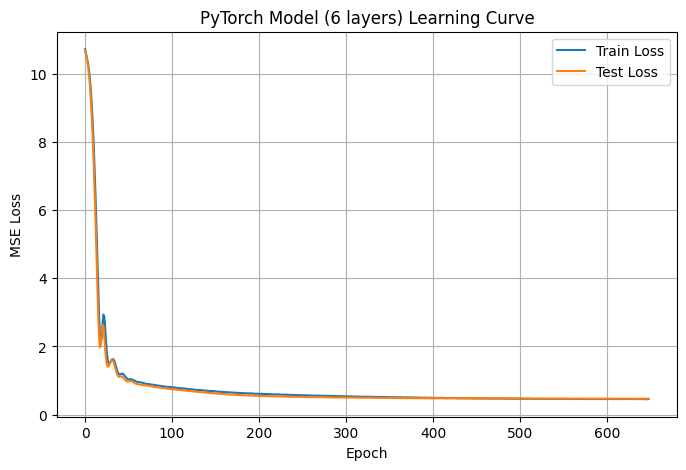

[PyTorch Model (6 layers) - Test Set]
MAE:  0.5497
RMSE: 0.6822
R²:   0.2789

[PyTorch Model (6 layers) - Training Set]
MAE:  0.5292
RMSE: 0.6551
R²:   0.3263


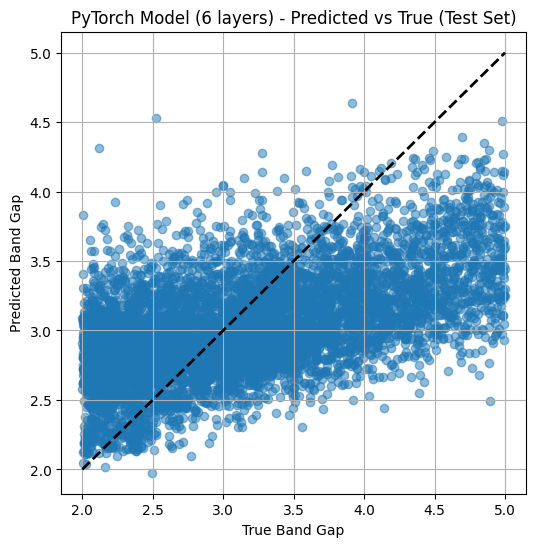

In [ ]:
# Make a metrics dictionary
model_layers6_metrics = evaluate_model(
    model_layers6,
    X_train_tensor,
    y_train,
    X_test_tensor,
    y_test
)
# Analyze the model
analyze_model(
    model_layers6_metrics,
    y_test,
    train_losses_layers6,
    test_losses_layers6,
    model_name="PyTorch Model (6 layers)"
)

## Ten Linear Layers Model

In [ ]:
import torch.nn as nn

class DeepRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),  # Layer 1
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 384),        # Layer 2
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(384, 256),        # Layer 3
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(256, 192),        # Layer 4
            nn.ReLU(),

            nn.Linear(192, 128),        # Layer 5
            nn.ReLU(),

            nn.Linear(128, 96),         # Layer 6
            nn.ReLU(),

            nn.Linear(96, 64),          # Layer 7
            nn.ReLU(),

            nn.Linear(64, 48),          # Layer 8
            nn.ReLU(),

            nn.Linear(48, 32),          # Layer 9
            nn.ReLU(),

            nn.Linear(32, 1)            # Layer 10 (Output)
        )

    def forward(self, x):
        return self.net(x)

# Initialize the model
model_layers10 = DeepRegressor(X_train_tensor.shape[1])


In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal GPU on Mac
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU (not on Mac usually)
else:
    device = torch.device("cpu")  # Fallback

print("Using device:", device)

model_layers10.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print(X_train_tensor.device)
print(y_train_tensor.device)

Using device: mps
mps:0
mps:0


In [ ]:
model_layers10, train_losses_layers10, test_losses_layers10 = train_model(
    model_layers10,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    n_epochs=5000,
    lr=0.001,
    weight_decay=0,
    early_stop_patience=200,
    scheduler_patience=50,
    scheduler_factor=0.5,
    verbose_every=20
)

Training:   0%|          | 1/5000 [00:00<13:42,  6.08it/s]

Epoch    0 | Train Loss: 10.1609 | Test Loss: 10.1678


Training:   0%|          | 24/5000 [00:01<04:19, 19.19it/s]

Epoch   20 | Train Loss: 2.1447 | Test Loss: 2.4203


Training:   1%|          | 45/5000 [00:02<03:46, 21.91it/s]

Epoch   40 | Train Loss: 1.1832 | Test Loss: 1.0703


Training:   1%|▏         | 63/5000 [00:03<03:41, 22.34it/s]

Epoch   60 | Train Loss: 0.8920 | Test Loss: 0.8280


Training:   2%|▏         | 84/5000 [00:04<04:11, 19.51it/s]

Epoch   80 | Train Loss: 0.7933 | Test Loss: 0.7289


Training:   2%|▏         | 105/5000 [00:05<03:43, 21.87it/s]

Epoch  100 | Train Loss: 0.7153 | Test Loss: 0.6487


Training:   2%|▏         | 123/5000 [00:05<03:35, 22.58it/s]

Epoch  120 | Train Loss: 0.6589 | Test Loss: 0.5820


Training:   3%|▎         | 144/5000 [00:06<03:38, 22.25it/s]

Epoch  140 | Train Loss: 0.6245 | Test Loss: 0.5504


Training:   3%|▎         | 165/5000 [00:07<03:34, 22.58it/s]

Epoch  160 | Train Loss: 0.5952 | Test Loss: 0.5296


Training:   4%|▎         | 183/5000 [00:08<03:34, 22.44it/s]

Epoch  180 | Train Loss: 0.5760 | Test Loss: 0.5219


Training:   4%|▍         | 204/5000 [00:09<03:32, 22.53it/s]

Epoch  200 | Train Loss: 0.5601 | Test Loss: 0.5145


Training:   4%|▍         | 225/5000 [00:10<03:41, 21.57it/s]

Epoch  220 | Train Loss: 0.5501 | Test Loss: 0.5143


Training:   5%|▍         | 243/5000 [00:11<03:37, 21.86it/s]

Epoch  240 | Train Loss: 0.5397 | Test Loss: 0.4916


Training:   5%|▌         | 264/5000 [00:12<03:37, 21.81it/s]

Epoch  260 | Train Loss: 0.5238 | Test Loss: 0.4975


Training:   6%|▌         | 285/5000 [00:13<03:30, 22.41it/s]

Epoch  280 | Train Loss: 0.5199 | Test Loss: 0.4882


Training:   6%|▌         | 303/5000 [00:14<03:28, 22.55it/s]

Epoch  300 | Train Loss: 0.5086 | Test Loss: 0.5022


Training:   6%|▋         | 324/5000 [00:15<03:31, 22.07it/s]

Epoch  320 | Train Loss: 0.5047 | Test Loss: 0.4669


Training:   7%|▋         | 342/5000 [00:15<04:03, 19.15it/s]

Epoch  340 | Train Loss: 0.4900 | Test Loss: 0.4731


Training:   7%|▋         | 365/5000 [00:16<03:35, 21.53it/s]

Epoch  360 | Train Loss: 0.4841 | Test Loss: 0.4887


Training:   8%|▊         | 383/5000 [00:17<03:28, 22.14it/s]

Epoch  380 | Train Loss: 0.4777 | Test Loss: 0.4645


Training:   8%|▊         | 404/5000 [00:18<03:20, 22.88it/s]

Epoch  400 | Train Loss: 0.4741 | Test Loss: 0.4966


Training:   8%|▊         | 425/5000 [00:19<03:18, 23.09it/s]

Epoch  420 | Train Loss: 0.4619 | Test Loss: 0.4641


Training:   9%|▉         | 443/5000 [00:20<03:16, 23.14it/s]

Epoch  440 | Train Loss: 0.4642 | Test Loss: 0.4875


Training:   9%|▉         | 464/5000 [00:21<03:16, 23.09it/s]

Epoch  460 | Train Loss: 0.4578 | Test Loss: 0.4496


Training:  10%|▉         | 485/5000 [00:22<03:14, 23.20it/s]

Epoch  480 | Train Loss: 0.4480 | Test Loss: 0.4788


Training:  10%|█         | 503/5000 [00:22<03:13, 23.23it/s]

Epoch  500 | Train Loss: 0.4403 | Test Loss: 0.4657


Training:  10%|█         | 524/5000 [00:23<03:12, 23.24it/s]

Epoch  520 | Train Loss: 0.4384 | Test Loss: 0.4763


Training:  11%|█         | 545/5000 [00:24<03:11, 23.22it/s]

Epoch  540 | Train Loss: 0.4367 | Test Loss: 0.4625


Training:  11%|█▏        | 563/5000 [00:25<03:10, 23.24it/s]

Epoch  560 | Train Loss: 0.4327 | Test Loss: 0.4631


Training:  12%|█▏        | 584/5000 [00:26<03:09, 23.25it/s]

Epoch  580 | Train Loss: 0.4307 | Test Loss: 0.4657


Training:  12%|█▏        | 605/5000 [00:27<03:09, 23.25it/s]

Epoch  600 | Train Loss: 0.4267 | Test Loss: 0.4660


Training:  12%|█▏        | 623/5000 [00:28<03:09, 23.15it/s]

Epoch  620 | Train Loss: 0.4252 | Test Loss: 0.4699


Training:  13%|█▎        | 644/5000 [00:29<03:07, 23.21it/s]

Epoch  640 | Train Loss: 0.4207 | Test Loss: 0.4660


Training:  13%|█▎        | 665/5000 [00:29<03:07, 23.15it/s]

Epoch  660 | Train Loss: 0.4216 | Test Loss: 0.4652


Training:  14%|█▎        | 683/5000 [00:30<03:05, 23.23it/s]

Epoch  680 | Train Loss: 0.4206 | Test Loss: 0.4672


Training:  14%|█▍        | 704/5000 [00:31<03:05, 23.19it/s]

Epoch  700 | Train Loss: 0.4190 | Test Loss: 0.4645


Training:  14%|█▍        | 706/5000 [00:31<03:13, 22.22it/s]


⏹️ Early stopping at epoch 706

✅ Training completed in 31.78 seconds (0.53 minutes)


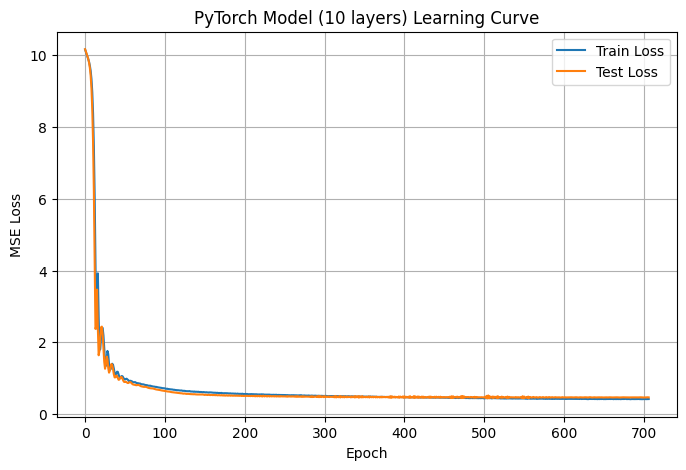

[PyTorch Model (10 layers) - Test Set]
MAE:  0.5446
RMSE: 0.6835
R²:   0.2759

[PyTorch Model (10 layers) - Training Set]
MAE:  0.5071
RMSE: 0.6344
R²:   0.3682


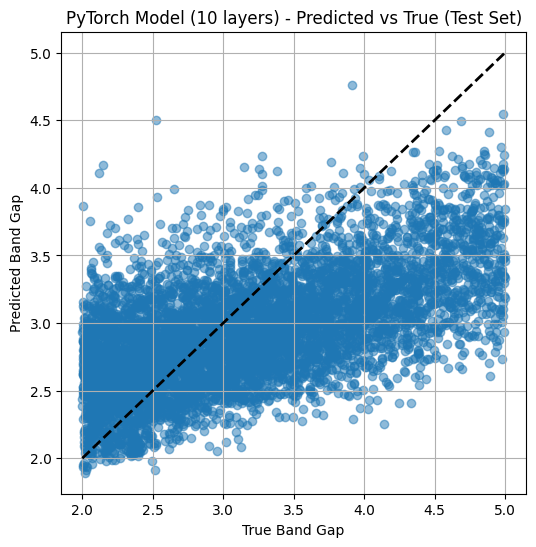

In [ ]:
# Evaluate model
# Make a metrics dictionary
model_layers10_metrics = evaluate_model(
    model_layers10,
    X_train_tensor,
    y_train,
    X_test_tensor,
    y_test
)
# Analyze the model
analyze_model(
    model_layers10_metrics,
    y_test,
    train_losses_layers10,
    test_losses_layers10,
    model_name="PyTorch Model (10 layers)"
)


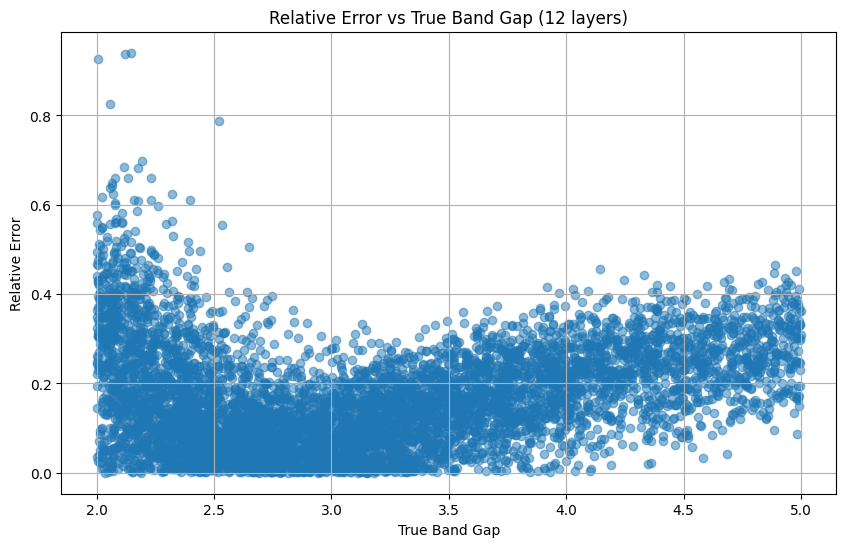

In [ ]:
# relative error vs true band gap plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, np.abs(model_layers10_metrics['test']['y_pred_test'].flatten() - y_test) / y_test, alpha=0.5)
plt.xlabel("True Band Gap")
plt.ylabel("Relative Error")
plt.title("Relative Error vs True Band Gap (12 layers)")
plt.grid(True)
plt.show()

## 12 Layers

In [ ]:
import torch.nn as nn

class DeepRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 768),   # Layer 1
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(768, 512),         # Layer 2
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 384),         # Layer 3
            nn.ReLU(),

            nn.Linear(384, 256),         # Layer 4
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(256, 192),         # Layer 5
            nn.ReLU(),

            nn.Linear(192, 128),         # Layer 6
            nn.ReLU(),

            nn.Linear(128, 96),          # Layer 7
            nn.ReLU(),

            nn.Linear(96, 72),           # Layer 8
            nn.ReLU(),

            nn.Linear(72, 48),           # Layer 9
            nn.ReLU(),

            nn.Linear(48, 32),           # Layer 10
            nn.ReLU(),

            nn.Linear(32, 16),           # Layer 11
            nn.ReLU(),

            nn.Linear(16, 1)             # Layer 12 (Output)
        )

    def forward(self, x):
        return self.net(x)

# Initialize the 12-layer model
model_layers12 = DeepRegressor(X_train_tensor.shape[1])


In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal GPU on Mac
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU (not on Mac usually)
else:
    device = torch.device("cpu")  # Fallback

print("Using device:", device)

model_layers12.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print(X_train_tensor.device)
print(y_train_tensor.device)

Using device: mps
mps:0
mps:0


In [ ]:
model_layers12, train_losses_layers12, test_losses_layers12 = train_model(
    model_layers12,
    X_train_tensor,
    y_train_tensor,
    X_test_tensor,
    y_test_tensor,
    n_epochs=5000,
    lr=0.001,
    weight_decay=0,
    early_stop_patience=200,
    scheduler_patience=50,
    scheduler_factor=0.5,
    verbose_every=20
)

Training:   0%|          | 2/5000 [00:00<06:27, 12.91it/s]

Epoch    0 | Train Loss: 11.0009 | Test Loss: 11.0265


Training:   0%|          | 22/5000 [00:01<05:57, 13.91it/s]

Epoch   20 | Train Loss: 2.3046 | Test Loss: 1.7420


Training:   1%|          | 42/5000 [00:03<05:55, 13.93it/s]

Epoch   40 | Train Loss: 1.1485 | Test Loss: 1.0083


Training:   1%|          | 62/5000 [00:04<05:54, 13.93it/s]

Epoch   60 | Train Loss: 0.8902 | Test Loss: 0.8358


Training:   2%|▏         | 82/5000 [00:05<05:53, 13.92it/s]

Epoch   80 | Train Loss: 0.8030 | Test Loss: 0.7469


Training:   2%|▏         | 102/5000 [00:07<05:51, 13.92it/s]

Epoch  100 | Train Loss: 0.7257 | Test Loss: 0.6643


Training:   2%|▏         | 122/5000 [00:08<05:50, 13.90it/s]

Epoch  120 | Train Loss: 0.6621 | Test Loss: 0.5952


Training:   3%|▎         | 142/5000 [00:10<05:48, 13.93it/s]

Epoch  140 | Train Loss: 0.6226 | Test Loss: 0.5595


Training:   3%|▎         | 162/5000 [00:11<05:45, 14.00it/s]

Epoch  160 | Train Loss: 0.5983 | Test Loss: 0.5453


Training:   4%|▎         | 182/5000 [00:13<05:43, 14.01it/s]

Epoch  180 | Train Loss: 0.5882 | Test Loss: 0.5255


Training:   4%|▍         | 202/5000 [00:14<05:43, 13.99it/s]

Epoch  200 | Train Loss: 0.5713 | Test Loss: 0.5178


Training:   4%|▍         | 222/5000 [00:15<05:42, 13.96it/s]

Epoch  220 | Train Loss: 0.5606 | Test Loss: 0.5176


Training:   5%|▍         | 242/5000 [00:17<05:49, 13.61it/s]

Epoch  240 | Train Loss: 0.5525 | Test Loss: 0.5168


Training:   5%|▌         | 262/5000 [00:18<05:39, 13.95it/s]

Epoch  260 | Train Loss: 0.5394 | Test Loss: 0.5267


Training:   6%|▌         | 282/5000 [00:20<05:43, 13.74it/s]

Epoch  280 | Train Loss: 0.5329 | Test Loss: 0.5290


Training:   6%|▌         | 302/5000 [00:21<05:49, 13.45it/s]

Epoch  300 | Train Loss: 0.5241 | Test Loss: 0.5207


Training:   6%|▋         | 322/5000 [00:23<06:28, 12.04it/s]

Epoch  320 | Train Loss: 0.5217 | Test Loss: 0.5343


Training:   7%|▋         | 342/5000 [00:24<05:51, 13.23it/s]

Epoch  340 | Train Loss: 0.5135 | Test Loss: 0.5354


Training:   7%|▋         | 362/5000 [00:26<05:59, 12.91it/s]

Epoch  360 | Train Loss: 0.5142 | Test Loss: 0.5412


Training:   8%|▊         | 382/5000 [00:27<05:45, 13.37it/s]

Epoch  380 | Train Loss: 0.5118 | Test Loss: 0.5497


Training:   8%|▊         | 402/5000 [00:29<05:44, 13.33it/s]

Epoch  400 | Train Loss: 0.5117 | Test Loss: 0.5572


Training:   8%|▊         | 422/5000 [00:30<05:33, 13.72it/s]

Epoch  420 | Train Loss: 0.5072 | Test Loss: 0.5571


Training:   9%|▉         | 442/5000 [00:32<05:27, 13.91it/s]

Epoch  440 | Train Loss: 0.5056 | Test Loss: 0.5604


Training:   9%|▉         | 456/5000 [00:33<05:32, 13.65it/s]


⏹️ Early stopping at epoch 456

✅ Training completed in 33.42 seconds (0.56 minutes)


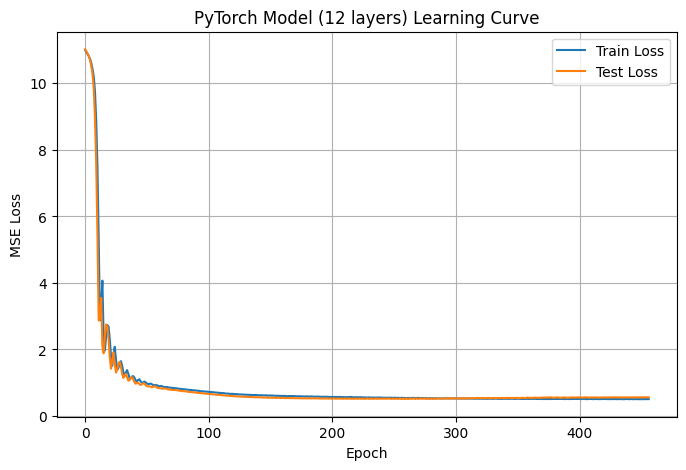

[PyTorch Model (12 layers) - Test Set]
MAE:  0.5995
RMSE: 0.7499
R²:   0.1285

[PyTorch Model (12 layers) - Training Set]
MAE:  0.5822
RMSE: 0.7278
R²:   0.1685


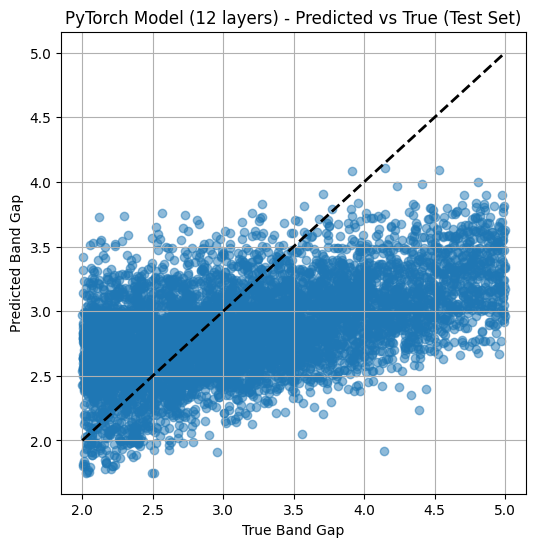

In [ ]:
# Make a metrics dictionary
model_layers12_metrics = evaluate_model(
    model_layers12,
    X_train_tensor,
    y_train,
    X_test_tensor,
    y_test
)
# Analyze the model
analyze_model(
    model_layers12_metrics,
    y_test,
    train_losses_layers12,
    test_losses_layers12,
    model_name="PyTorch Model (12 layers)"
)

In [ ]:
# shape of model_layers12_metrics['test']['y_pred_test']
print(model_layers12_metrics['test']['y_pred_test'].shape)
print(y_test.shape)

(6558, 1)
(6558,)


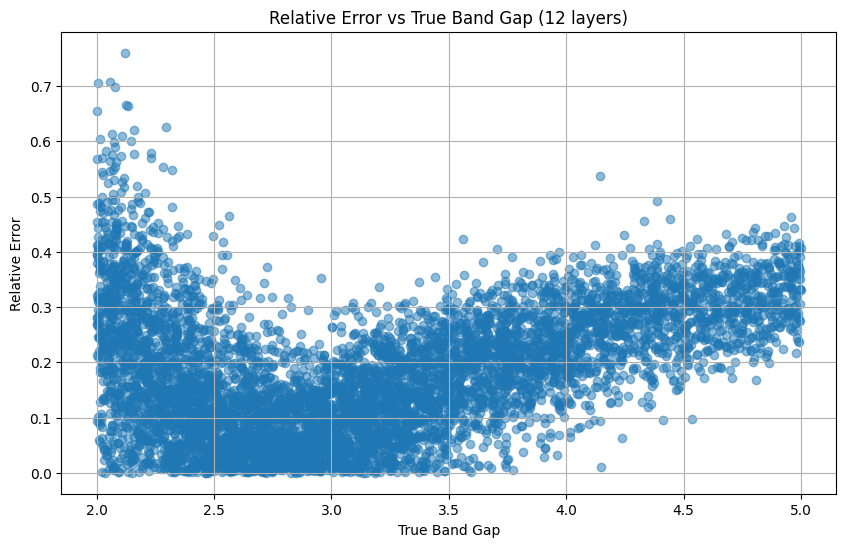

In [ ]:
# relative error vs true band gap plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, np.abs(model_layers12_metrics['test']['y_pred_test'].flatten() - y_test) / y_test, alpha=0.5)
plt.xlabel("True Band Gap")
plt.ylabel("Relative Error")
plt.title("Relative Error vs True Band Gap (12 layers)")
plt.grid(True)
plt.show()

## Ensemble Predictions

In [ ]:
def ensemble_predict(models, X_tensor):
    """
    Averages predictions from multiple models.

    Args:
        models (list): List of trained PyTorch models
        X_tensor (torch.Tensor): Input features

    Returns:
        np.ndarray: Averaged predictions (numpy array)
    """
    preds = []

    for model in models:
        model.eval()
        with torch.no_grad():
            pred = model(X_tensor).detach().cpu().numpy()
            preds.append(pred)

    # Stack and average predictions
    preds = np.stack(preds, axis=0)  # Shape: (num_models, num_samples, 1)
    avg_preds = np.mean(preds, axis=0)  # Shape: (num_samples, 1)

    return avg_preds


In [ ]:
# Assume you have 3 trained models
# models["Random Forest"].fit(X_train_processed, y_train)
models = [model_layers3, model_layers6]

# Ensemble predictions on test data
ensemble_preds = ensemble_predict(models, X_test_tensor)

mae = mean_absolute_error(y_test, ensemble_preds)
rmse = mean_squared_error(y_test, ensemble_preds)
r2 = r2_score(y_test, ensemble_preds)

print(f"[Ensemble Results models 6 and 10 layers]")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

[Ensemble Results models 6 and 10 layers]
MAE:  0.5257
RMSE: 0.4244
R²:   0.3423


### Less Layers but more iterations?

In [ ]:
# residuals = y_test - y_pred_torch.flatten()

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=y_pred_torch.flatten(), y=residuals)
# plt.axhline(0, linestyle='--', color='red')
# plt.xlabel('Predicted')
# plt.ylabel('Residuals')
# plt.title('Residuals vs. Predicted')
# plt.grid(True)
# plt.show()


In [ ]:
# plt.figure(figsize=(8, 6))
# sns.histplot(residuals, kde=True)
# plt.title('Distribution of Residuals')
# plt.xlabel('Residual')
# plt.grid(True)
# plt.show()


#### Posibly Add Weight Initialization

In [ ]:
# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         nn.init.kaiming_normal_(m.weight)
#         if m.bias is not None:
#             nn.init.zeros_(m.bias)

# model2.apply(init_weights)

In [ ]:
# Print the summaries of all the models based on mae rmse and r2#
# Use also the metrics from the above models

# Summary of all

In [ ]:
# Print the summaries of all the models based on mae rmse and r2#
# summarize all model by mae and r2 values
print("\nSummary of all models: band gap range 2 - 5.0")
print(f"{'Model':<30} {'MAE':<10} {'RMSE':<10} {'R²':<10}")
for name, result in results.items():
    print(f"{name:<30} {result['mae']:<10.4f} {np.sqrt(result['mae']):<10.4f} {result['r2']:<10.4f}")
print(f"{'PyTorch 3-layers':<30} {model_layers3_metrics['test']['MAE']:<10.4f} {model_layers3_metrics['test']['RMSE']:<10.4f} {model_layers3_metrics['test']['R2']:<10.4f}")
# print(f"{'PyTorch 3-layers train':<30} {model_layers3_metrics['train']['MAE']:<10.4f} {model_layers3_metrics['train']['RMSE']:<10.4f} {model_layers3_metrics['train']['R2']:<10.4f}")
print(f"{'PyTorch 6-layers':<30} {model_layers6_metrics['test']['MAE']:<10.4f} {model_layers6_metrics['test']['RMSE']:<10.4f} {model_layers6_metrics['test']['R2']:<10.4f}")
# print(f"{'PyTorch 6-layers train':<30} {model_layers6_metrics['train']['MAE']:<10.4f} {model_layers6_metrics['train']['RMSE']:<10.4f} {model_layers6_metrics['train']['R2']:<10.4f}")
print(f"{'PyTorch 10-layers':<30} {model_layers10_metrics['test']['MAE']:<10.4f} {model_layers10_metrics['test']['RMSE']:<10.4f} {model_layers10_metrics['test']['R2']:<10.4f}")
# print(f"{'PyTorch 10-layers train':<30} {model_layers10_metrics['train']['MAE']:<10.4f} {model_layers10_metrics['train']['RMSE']:<10.4f} {model_layers10_metrics['train']['R2']:<10.4f}")
print(f"{'PyTorch 12-layers':<30} {model_layers12_metrics['test']['MAE']:<10.4f} {model_layers12_metrics['test']['RMSE']:<10.4f} {model_layers12_metrics['test']['R2']:<10.4f}")
print(f"{'Ensemble 3 and 6 layers':<30} {mae:<10.4f} {rmse:<10.4f} {r2:<10.4f}")


Summary of all models: band gap range 2 - 5.0
Model                          MAE        RMSE       R²        
Dummy                          0.6740     0.8210     -0.0002   
Linear Regression              0.6251     0.7906     0.1198    
Ridge Regression               0.6251     0.7906     0.1198    
Random Forest                  0.4269     0.6534     0.5346    
PyTorch 3-layers               0.5278     0.6608     0.3233    
PyTorch 6-layers               0.5497     0.6822     0.2789    
PyTorch 10-layers              0.5446     0.6835     0.2759    
PyTorch 12-layers              0.5995     0.7499     0.1285    
Ensemble 3 and 6 layers        0.5257     0.4244     0.3423    


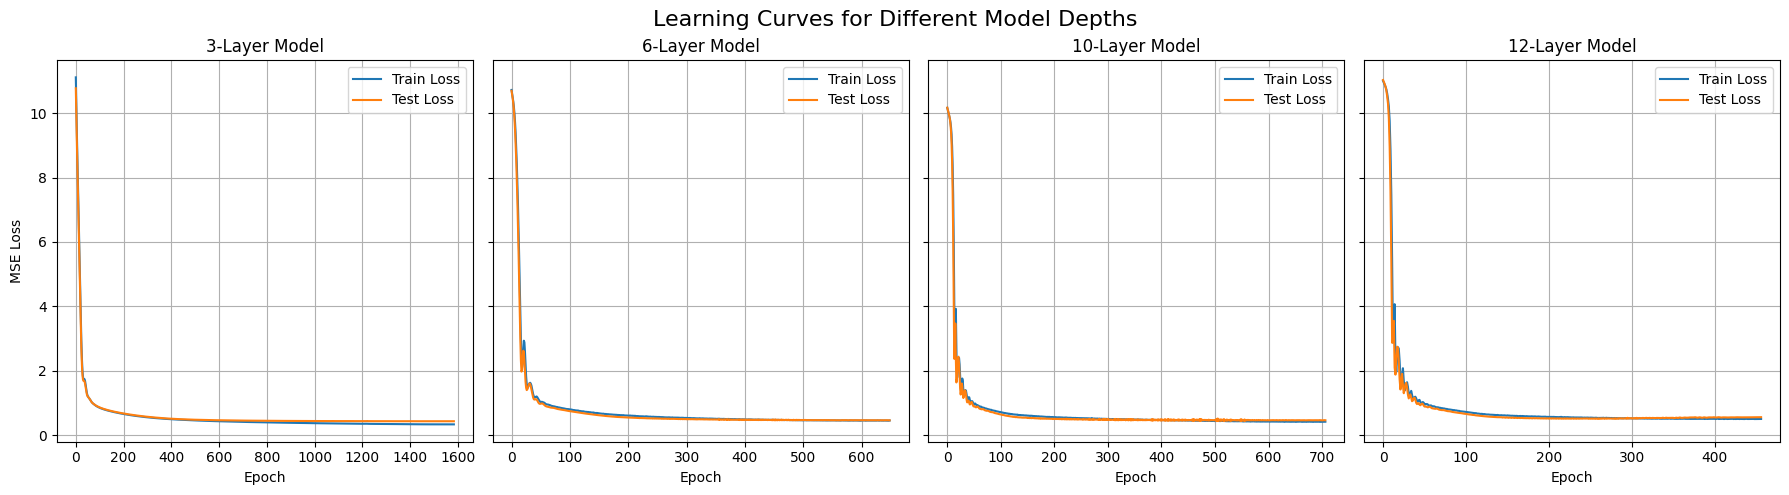

In [ ]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharey=True)

# Model: 3 Layers
axes[0].plot(train_losses_layers3, label="Train Loss")
axes[0].plot(test_losses_layers3, label="Test Loss")
axes[0].set_title("3-Layer Model")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE Loss")
axes[0].legend()
axes[0].grid(True)

# Model: 6 Layers
axes[1].plot(train_losses_layers6, label="Train Loss")
axes[1].plot(test_losses_layers6, label="Test Loss")
axes[1].set_title("6-Layer Model")
axes[1].set_xlabel("Epoch")
axes[1].legend()
axes[1].grid(True)

# Model: 10 Layers
axes[2].plot(train_losses_layers10, label="Train Loss")
axes[2].plot(test_losses_layers10, label="Test Loss")
axes[2].set_title("10-Layer Model")
axes[2].set_xlabel("Epoch")
axes[2].legend()
axes[2].grid(True)

# Model: 12 Layers
axes[3].plot(train_losses_layers12, label="Train Loss")
axes[3].plot(test_losses_layers12, label="Test Loss")
axes[3].set_title("12-Layer Model")
axes[3].set_xlabel("Epoch")
axes[3].legend()
axes[3].grid(True)


# Set overall title
fig.suptitle("Learning Curves for Different Model Depths", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()



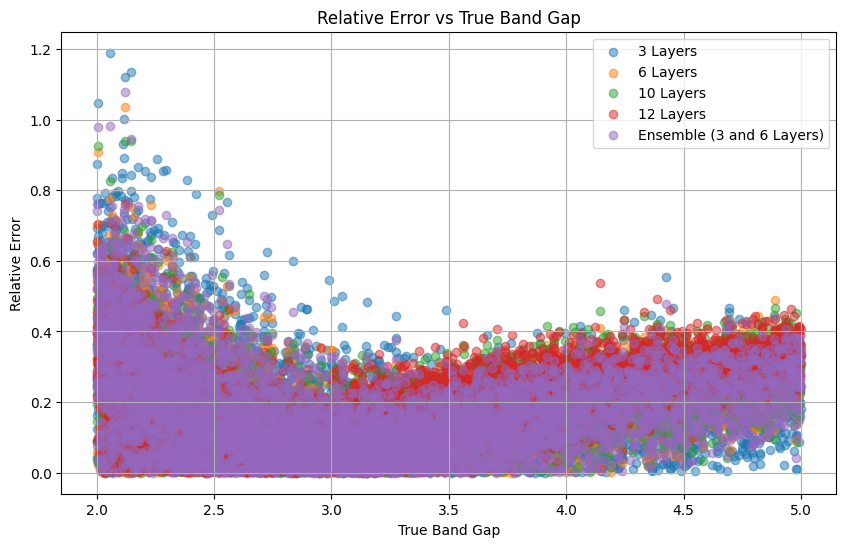

In [ ]:
# relative error vs true band gap for 3 6 10 and 12 layers
plt.figure(figsize=(10, 6))
plt.scatter(y_test, np.abs(model_layers3_metrics['test']['y_pred_test'].flatten() - y_test) / y_test, alpha=0.5, label="3 Layers")
plt.scatter(y_test, np.abs(model_layers6_metrics['test']['y_pred_test'].flatten() - y_test) / y_test, alpha=0.5, label="6 Layers")
plt.scatter(y_test, np.abs(model_layers10_metrics['test']['y_pred_test'].flatten() - y_test) / y_test, alpha=0.5, label="10 Layers")
plt.scatter(y_test, np.abs(model_layers12_metrics['test']['y_pred_test'].flatten() - y_test) / y_test, alpha=0.5, label="12 Layers")
plt.scatter(y_test, np.abs(ensemble_preds.flatten() - y_test) / y_test, alpha=0.5, label="Ensemble (3 and 6 Layers)")
plt.xlabel("True Band Gap")
plt.ylabel("Relative Error")
plt.title("Relative Error vs True Band Gap")
plt.legend()
plt.grid(True)
plt.show()